# ติดตั้งไลบรารี (รันครั้งแรก)

In [8]:
!pip install -q joblib scikit-learn matplotlib seaborn tldextract xgboost
# Imports หลักที่ใช้ในงานนี้:
# - จัดการข้อมูลและ URL (pandas, tldextract, urllib)
# - สร้างฟีเจอร์เชิงตัวเลขและ TF-IDF (sklearn, scipy.sparse)
# - เทรนและประเมินโมเดล Machine Learning (sklearn, xgboost)
# - แสดงผลด้วยกราฟ (matplotlib, seaborn)
# - บันทึกและโหลดโมเดล (joblib)

import os
import re
import tldextract
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import log2
from urllib.parse import urlparse


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, f1_score

from scipy.sparse import hstack, csr_matrix

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb


 config

In [3]:
ALL_CSV = 'extracted_features.csv' #ชื่อไฟล์ที่จะนำมาเทรน
SAMPLE_N = None   # ใส่จำนวนเช่นที่จะเทรน None คือเทรนทั้งData set
RANDOM_STATE = 42
#ไว้เช็คถ้าไม่เจอ
if not os.path.exists(ALL_CSV):
    raise FileNotFoundError(f"ไฟล์ {ALL_CSV} ไม่พบใน working dir. ตรวจสอบชื่อ/อัปโหลดไฟล์ก่อนรัน")

#โหลด CSV เข้า pandas DataFrame df
df = pd.read_csv(ALL_CSV)
print("Initial columns:", df.columns.tolist()) #แสดงชื่อคอลัมน์และจำนวนแถว
print("Initial rows:", len(df))

#เช็กก่อนว่า Dataset มีคอลัมน์ชื่อ label ไหม ถ้าไม่มีบล็อกนี้จะไม่ทำงาน
if 'label' in df.columns:
    try:
        df['label'] = df['label'].astype(int) #แปลงคอลัมน์ label เป็น int

    #เมื่อค่ามีเป็นข้อความ เช่น "phishing", "benign", "malicious", หรือค่าที่ไม่ใช่ตัวเลขโดยตรงในกรณีนี้โค้ดจะเข้าส่วน mapping เพื่อแปลงข้อความเหล่านั้นเป็น 0/1
    except:
        #ถ้าค่าตรงกับคำใน mapping ให้แปลงเป็น 1 (หมายถึง phishing) หรือ 0 (หมายถึง legit)
        mapping = {'phishing':1,'phish':1,'malicious':1,'malware':1,'defacement':1,
                   'benign':0,'legit':0,'clean':0}
        df['label'] = df['label'].astype(str).str.lower().map(mapping)
        df = df.dropna(subset=['label']) #ตัดแถวที่ label เป็น NaN ออกไป เพราะแปลค่าไม่ได้
        df['label'] = df['label'].astype(int) #แปลงคอลัมน์ label อีกครั้งเป็น int

#บาง dataset จะไม่มีคอลัมน์ชื่อ "label"แต่จะมี "type" เเทน
elif 'type' in df.columns:
    # ถ้ามีคอลัมน์ type ที่เป็นคำ เช่น 'benign','phishing' ให้แม็ป
    mapping = {'phishing':1,'phish':1,'malicious':1,'malware':1,'defacement':1,
               'benign':0,'legit':0,'clean':0,'other':1}
    df['label'] = df['type'].astype(str).str.lower().map(mapping)
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

#บาง dataset ไม่มี "label","type"แต่มีคอลัมน์ "source_file"
elif 'source_file' in df.columns:
    df['label'] = df['source_file'].astype(str).str.lower().apply(lambda s: 1 if 'phish' in s or 'malicious' in s else 0) #ถ้าในชื่อไฟล์มีคำว่า "phish" หรือ "malicious" → ให้เป็น 1 นอกนั้นให้เป็น 0
#ไม่มีอะไรเลย → error
else:
    raise ValueError("ไฟล์ไม่มีคอลัมน์ 'label' หรือ 'type' หรือ 'source_file' ที่จะแม็ปเป็น 0/1 — แก้ไฟล์ก่อน")

print("After mapping, rows:", len(df))
print("Label distribution:\n", df['label'].value_counts())

# --- ถ้ามากเกินไปจะช้า ให้ตั้ง sample โค้ดอยู่ด้านบน +---
if SAMPLE_N is not None and SAMPLE_N < len(df):
    df = df.sample(SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Sampled rows:", len(df))

# --- แยก train/test (80/20) และบันทึกไฟล์ สำหรับ pipeline ต่อไป ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df['label'])
print("Train:", len(train_df), "Test:", len(test_df))

#--- เซฟไฟล์ train/test ---
train_df.to_csv('train_urls.csv', index=False)
test_df.to_csv('test_urls.csv', index=False)
print("Saved train_urls.csv and test_urls.csv — พร้อมรันเซลล์ถัดไปเพื่อสร้างฟีเจอร์และเทรน")


Initial columns: ['url_len', 'num_dots', 'num_slash', 'has_at', 'has_hyphen', 'is_ip', 'num_query', 'suspicious_token_count', 'has_https', 'has_http', 'num_digits', 'url', 'label', 'source_file']
Initial rows: 10000
After mapping, rows: 10000
Label distribution:
 label
0    5000
1    5000
Name: count, dtype: int64
Train: 8000 Test: 2000
Saved train_urls.csv and test_urls.csv — พร้อมรันเซลล์ถัดไปเพื่อสร้างฟีเจอร์และเทรน


# (ถ้าไม่มี features.py) ฟังก์ชันสร้าง numeric features

In [9]:
#คำเสี่ยงที่ Hacker ชอบใช้
SENSITIVE_TOKENS = [
    'login', 'secure', 'update', 'verify', 'account', 'signin', 'wp-login', 'confirm',
    'banking', 'paypal', 'limited', 'suspend', 'client', 'payment', 'bill', 'invoice',
    'admin', 'service', 'bonus', 'free', 'gift', 'netflix', 'apple', 'google', 'hotmail',
    'yahoo', 'support', 'protect', 'secure', 'safe'
]

#นามสกุลโดเมนเสี่ยง
RISKY_TLDS = {'xyz', 'top', 'club', 'online', 'vip', 'tk', 'ml', 'ga', 'cf', 'gq', 'men', 'loan', 'date', 'win', 'cn', 'ru'}
#คำมั่วของตัวอัการ
def shannon_entropy(s: str) -> float:
    if not s: return 0.0
    freq = {}
    for c in s: freq[c] = freq.get(c, 0) + 1
    L = len(s)
    return -sum((f/L) * log2(f/L) for f in freq.values())

def is_shortened(url: str) -> int:
    #ลิ้งตัวย่อ
    shorteners = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                 r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                 r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                 r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                 r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                 r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co"
    return int(bool(re.search(shorteners, url, flags=re.IGNORECASE)))
#ฟังก์ชันหลักที่สกัดฟีเจอร์
def extract_basic_features(url: str) -> dict:
    parsed = urlparse(url)
    host = (parsed.netloc or parsed.path or "").lower()
    ext = tldextract.extract(host)
    path = parsed.path or ''

    feats = {}

    feats['url_length'] = len(url)
    feats['hostname_length'] = len(host)
    feats['num_dots'] = host.count('.')
    feats['num_hyphens'] = host.count('-')
    feats['num_slash'] = url.count('/')
    feats['num_query'] = url.count('?') + url.count('&')
    feats['num_digits'] = sum(c.isdigit() for c in url)

    # --- Advanced Features (ของใหม่ที่เพิ่มให้) ---
    # มี IP ใน URL หรือไม่
    feats['has_ip'] = int(bool(re.match(r'^\d+\.\d+\.\d+\.\d+$', host)))
    # ไม่ใช่ HTTPS หรือไม่
    feats['no_https'] = int(not url.lower().startswith('https'))
    # เป็นลิงก์ย่อหรือไม่
    feats['is_shortened'] = is_shortened(url)
    # มีอักษร Punycode (xn--) หรือไม่
    feats['has_punycode'] = 1 if "xn--" in host else 0
    # ใช้นามสกุลโดเมนเสี่ยงหรือไม่ (.xyz, .top, etc.)
    feats['is_risky_tld'] = 1 if ext.suffix in RISKY_TLDS else 0

    # --- Entropy & Structure ---
    feats['entropy_host'] = shannon_entropy(host)
    feats['entropy_path'] = shannon_entropy(path)

    # นับจำนวน Subdomain
    feats['subdomain_levels'] = len([d for d in ext.subdomain.split('.') if d]) if ext.subdomain else 0

    # นับคำเสี่ยงใน URL
    feats['num_sensitive_tokens'] = sum(int(t in url.lower()) for t in SENSITIVE_TOKENS)

    return feats

def create_features_from_url(url: str, numeric_feature_names: list):
    ex = extract_basic_features(url)
    # return as dict (we'll build DataFrame outside)
    return {k: ex.get(k, 0) for k in numeric_feature_names}

# โหลดข้อมูล (ถ้ามีไฟล์แยก) / หรือรวมแล้ว split

In [10]:
# ถ้ามีไฟล์แยก train/val/test: โหลดตรงนี้
TRAIN_CSV = 'train_urls.csv'
TEST_CSV = 'test_urls.csv'

if os.path.exists(TRAIN_CSV) and os.path.exists(TEST_CSV):
    df_train = pd.read_csv(TRAIN_CSV)
    df_test = pd.read_csv(TEST_CSV)
else:
    # ถ้ามีไฟล์เดียว ALL_CSV ให้สุ่มแบ่ง
    df = pd.read_csv(ALL_CSV)
    # map label ถ้าจำเป็น (เช่น type -> 0/1) — ปรับ mapping ตามไฟล์ของมึง
    # df['label'] = df['type'].map({'benign':0,'phishing':1,'malware':1,'defacement':1,'other':1})
    if SAMPLE_N:
        df = df.sample(SAMPLE_N, random_state=RANDOM_STATE)
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df['label'])

print("Train rows:", len(df_train), "Test rows:", len(df_test))
df_train.head()

Train rows: 8000 Test rows: 2000


,url_len,num_dots,num_slash,has_at,has_hyphen,is_ip,num_query,suspicious_token_count,has_https,has_http,num_digits,url,label,source_file
0,78,4,7,0,0,0,0,0,1,1,16,https://www.archiver.rootsweb.ancestry.com/th/...,0,URL dataset.csv
1,32,2,3,0,0,0,1,0,1,1,0,https://www.eenicdp.cn/?ifxunsdt,1,Phishing URLs.csv
2,53,3,4,0,0,0,0,0,1,1,0,https://www.articles.latimes.com/keyword/marlo...,0,URL dataset.csv
3,29,2,3,0,0,0,0,0,1,1,0,https://aeon.cdjinbh.com/aeon,1,Phishing URLs.csv
4,18,2,2,0,0,0,0,0,1,1,0,https://www.si.com,0,URL dataset.csv


# สร้าง numeric feature list และ DataFrame

In [11]:
#สร้าง list ของชื่อฟีเจอร์
numeric_features = [
    'url_length', 'hostname_length', 'num_dots', 'num_hyphens', 'num_slash', 'num_query', 'num_digits',
    'has_ip', 'no_https', 'is_shortened', 'has_punycode', 'is_risky_tld',
    'entropy_host', 'entropy_path', 'subdomain_levels', 'num_sensitive_tokens'
]

def build_numeric_df(urls):
    rows = [ create_features_from_url(u, numeric_features) for u in urls ]
    return pd.DataFrame(rows)

X_num_train = build_numeric_df(df_train['url'].astype(str).tolist())
X_num_test  = build_numeric_df(df_test['url'].astype(str).tolist())

print("New numeric train shape:", X_num_train.shape)
X_num_train.head()

New numeric train shape: (8000, 16)


,url_length,hostname_length,num_dots,num_hyphens,num_slash,num_query,num_digits,has_ip,no_https,is_shortened,has_punycode,is_risky_tld,entropy_host,entropy_path,subdomain_levels,num_sensitive_tokens
0,78,34,4,0,7,0,16,0,0,0,0,0,3.785561,4.284528,3,0
1,32,14,2,0,3,1,0,0,0,0,0,1,2.896292,-0.000000,1,0
2,53,24,3,0,4,0,0,0,0,0,0,0,3.522055,3.880180,2,0
3,29,16,2,0,3,0,0,0,0,0,0,0,3.500000,2.321928,1,0
4,18,10,2,0,2,0,0,0,0,0,0,0,2.646439,0.000000,1,0


# สร้าง TF-IDF จาก path+query (fit on train)

In [13]:
# 1. ตั้งค่าการทำ TF-IDF
#    เราจะให้คอมพิวเตอร์ดู ชุดตัวอักษร ใน URL ยาว 3–5 ตัว
#    เพราะเว็บฟิชชิ่งมักมีคำหรือรูปแบบแปลก ๆ อยู่ใน path/query
TFIDF_NGRAM_RANGE = (3, 5)
TFIDF_MAX_FEATURES = 8000

# 2) สร้างตัวแปลงข้อความเป็นตัวเลข (TF-IDF)
#    ใช้แบบ character เพราะ URL ไม่ใช่ประโยค ไม่มีคำแบ่งชัดเจน
tfidf = TfidfVectorizer(
    analyzer='char_wb',  # ดูทีละตัวอักษร
    ngram_range=TFIDF_NGRAM_RANGE,
    min_df=5,   # จะเก็บเฉพาะรูปแบบที่เจออย่างน้อย 5 ครั้ง
    max_features=TFIDF_MAX_FEATURES
)

def path_query_list(urls):
    # ดึงเฉพาะส่วน path + query ของ URL
    # เช่น "/login?id=1"
    # เพราะคำที่ใช้หลอกเหยื่อมักถูกซ่อนไว้ตรงนี้
    return [ (urlparse(u).path or '') + '?' + (urlparse(u).query or '') for u in urls ]


# 3) เตรียมข้อมูลสำหรับ TF-IDF
#    แปลง URL ทั้งหมดให้เหลือแค่ path/query ตามข้อด้านบน
texts_train = path_query_list(df_train['url'].astype(str).tolist())
texts_test  = path_query_list(df_test['url'].astype(str).tolist())

# 4. fit กับ train, transform กับ test เท่านั้น เพื่อไม่ให้โมเดลโกงข้อมูล test
X_tfidf_train = tfidf.fit_transform(texts_train)
X_tfidf_test  = tfidf.transform(texts_test)

print("TFIDF shape:", X_tfidf_train.shape)

TFIDF shape: (8000, 8000)


# scale numeric features + combine (sparse)

In [14]:
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train.fillna(0))
X_num_test_scaled  = scaler.transform(X_num_test.fillna(0))

X_train = hstack([csr_matrix(X_num_train_scaled), X_tfidf_train])
X_test  = hstack([csr_matrix(X_num_test_scaled),  X_tfidf_test])

y_train = df_train['label'].astype(int).values
y_test  = df_test['label'].astype(int).values

print("Combined X_train shape:", X_train.shape)

Combined X_train shape: (8000, 8016)


# train XGBoost (sklearn API) with early stopping

In [16]:
#เช็กจำนวน 0/1 ใน label
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("pos/neg:", pos, neg, "scale_pos_weight:", scale_pos_weight)

# --- 1. ย้าย eval_metric และ early_stopping_rounds มาใส่ตรงนี้ ---
model = XGBClassifier(
    n_estimators=400, #ให้โมเดลสร้างต้นไม้สูงสุด 400 ต้น
    learning_rate=0.05, #เรียนรู้ช้า ๆ เพื่อความแม่นยำสูงกว่า เสี่ยง overfitting น้อย
    max_depth=6, #จำกัดความลึกของต้นไม้ (ยิ่งลึก = อาจจำข้อมูลมากเกินไป)
    subsample=0.9, #ใช้ 90% ของข้อมูลในการสร้างแต่ละต้น ลด overfitting
    colsample_bytree=0.8, #ใช้ 80% ของฟีเจอร์ในการสร้างต้น ลด overfitting
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="auc",
    early_stopping_rounds=50   #ถ้า 50 รอบหลังสุดคะแนนไม่ดีขึ้น ให้หยุดเทรน
)

#แบ่งข้อมูล train/validation สำหรับ early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=y_train
)

#เทรนโมเดลด้วย early stopping
model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=True
)

pos/neg: 4000 4000 scale_pos_weight: 1.0
[0]	validation_0-auc:0.91158
[1]	validation_0-auc:0.91348
[2]	validation_0-auc:0.92965
[3]	validation_0-auc:0.93221
[4]	validation_0-auc:0.93222
[5]	validation_0-auc:0.93332
[6]	validation_0-auc:0.93446
[7]	validation_0-auc:0.94520
[8]	validation_0-auc:0.96391
[9]	validation_0-auc:0.96698
[10]	validation_0-auc:0.96723
[11]	validation_0-auc:0.96734
[12]	validation_0-auc:0.96793
[13]	validation_0-auc:0.96822
[14]	validation_0-auc:0.96831
[15]	validation_0-auc:0.96854
[16]	validation_0-auc:0.96876
[17]	validation_0-auc:0.96912
[18]	validation_0-auc:0.96938
[19]	validation_0-auc:0.96985
[20]	validation_0-auc:0.97202
[21]	validation_0-auc:0.97162
[22]	validation_0-auc:0.97315
[23]	validation_0-auc:0.97310
[24]	validation_0-auc:0.97264
[25]	validation_0-auc:0.97371
[26]	validation_0-auc:0.97378
[27]	validation_0-auc:0.97464
[28]	validation_0-auc:0.97464
[29]	validation_0-auc:0.97505
[30]	validation_0-auc:0.97569
[31]	validation_0-auc:0.97593
[32]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_parallel_tree=None, ...)

Evaluate on test set

Chosen threshold by precision≥0.90: thr=0.1717, prec=0.901, recall=0.980
Threshold used: 0.1717
Accuracy: 0.9320
Precision: 0.9015
Recall: 0.9700
F1: 0.9345
ROC AUC: 0.9884
PR AUC: 0.9900
Brier score: 0.0389


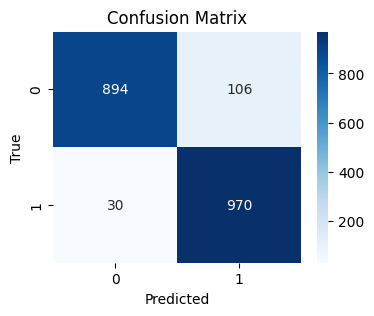

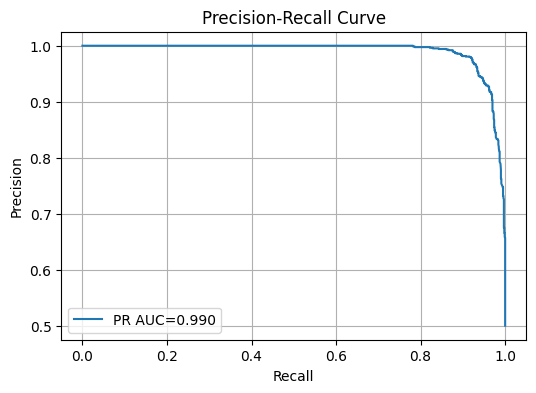

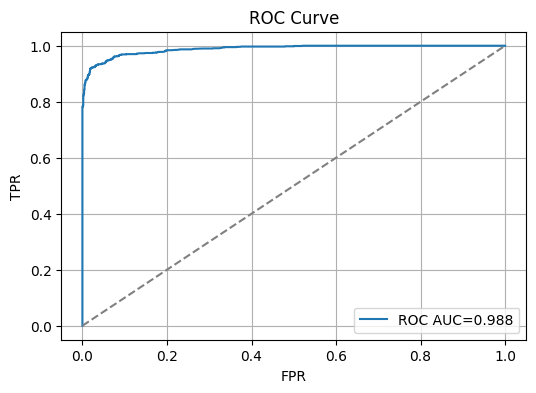

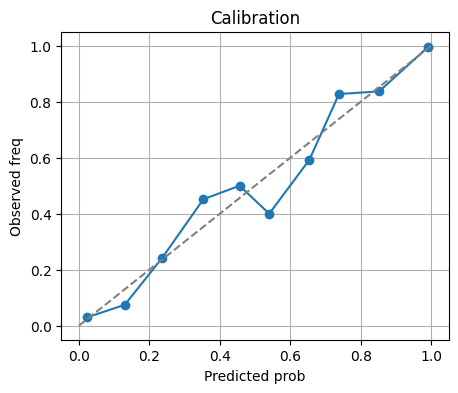

Top FP:


,url,label,prob
1222,https://www.kino-hd1080.ru,0,0.956854
344,https://www.artillery-museum.ru/en/collection....,0,0.955373
1493,https://www.april-wine.freedownloadmp3.net/,0,0.918525
125,https://www.aspen-electronics.com/,0,0.910360
1874,https://www.arashic0804.typepad.com/blog/,0,0.896850
130,https://www.ashbyroundtable.com/,0,0.857883
1148,https://www.asiatownitpark.com/structures/?view=7,0,0.848250
45,https://www.arborupdate.com/article/1642/publi...,0,0.827439
502,https://www.ariel-rebel-galleries.thumblogger....,0,0.825917
1534,https://www.architectureforhumanity.org/projects,0,0.822360


Top FN:


,url,label,prob
1774,https://www.qwvkd.cn,1,0.013233
1218,https://www.sckpjc.com,1,0.014705
1277,https://www.xxahe.cn,1,0.017766
1088,https://www.puluhw.com,1,0.036581
1863,https://www.qwfrsx.com,1,0.040287
528,https://dmlrvb.clicks.mlsend.com/tf/cl/eyJ2Ijo...,1,0.047104
182,https://www.tcmghf.com,1,0.049720
157,https://www.kvmuvh.com,1,0.049720
1851,https://depl.pages.dev,1,0.049720
491,https://dedicatess.pages.dev,1,0.054998


In [18]:
 # นำ metric ต่าง ๆ ที่ใช้วัดความแม่นยำของโมเดลมาใช้
  (
    precision_recall_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    auc,
    brier_score_loss,
    confusion_matrix,
    roc_curve
)


# 1) ดึงค่าความน่าจะเป็น  จากโมเดล ถ้ามี "calibrated model" ให้ใช้แทน
probs = model.predict_proba(X_test)[:,1]

# 2) เลือก threshold ใช้จาก validation set เป้าหมาย: ให้ precision ≥ 90%
probs_val = model.predict_proba(X_val)[:,1]

# คำนวณความสัมพันธ์ระหว่าง precision, recall และ threshold
prec, rec, ths = precision_recall_curve(y_val, probs_val)

# ตั้งเป้าว่าอยากให้ precision >= 90%
target_precision = 0.90

# หา threshold ที่ precision ถึงเป้าหมาย
candidates = [(p, r, t) for p, r, t in zip(prec, rec, list(ths) + [1.0]) if p >= target_precision]

if candidates:
  # ถ้ามีหลาย threshold เลือกอันที่ recall สูงสุด (ระบุ phishing ได้เยอะสุด)
    best_p, best_r, best_threshold = max(candidates, key=lambda x: x[1])
    print(f"Chosen threshold by precision≥{target_precision:.2f}: thr={best_threshold:.4f}, prec={best_p:.3f}, recall={best_r:.3f}")
# ถ้า precision >= 90% หาค่าไม่ได้ → fallback: ใช้ threshold ที่ให้ F1 ดีที่สุด
else:
    f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
    best_idx = f1_scores.argmax()
    ths_list = list(ths) + [1.0]
    best_threshold = ths_list[best_idx]
    print(f"No candidate met precision≥{target_precision:.2f}. Fallback threshold by F1: {best_threshold:.4f}")

# 3) ใช้ threshold ที่เลือกไว้กับ test set เพื่อทำนาย 0/1
y_pred = (probs > best_threshold).astype(int)

# 4) คำนวณทุก metric ที่สำคัญ ใช้สรุปผลการทำงานของโมเดล
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, probs)
prec_curve, rec_curve, ths_plot = precision_recall_curve(y_test, probs)
pr_auc = auc(rec_curve, prec_curve)
brier = brier_score_loss(y_test, probs)

print(f"Threshold used: {best_threshold:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Brier score: {brier:.4f}")

# ดูว่าโมเดลเดาผิดตรงไหนบ้าง
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

#ใช้ดูว่าโมเดลดีขนาดไหนใน class ไม่บาลานซ์
plt.figure(figsize=(6,4))
plt.plot(rec_curve, prec_curve, label=f'PR AUC={pr_auc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.grid(True); plt.legend(); plt.show()

#ดูความสามารถแยกระหว่าง phishing vs legit
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC={roc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True); plt.show()

#Probability โมเดลตรงกับความจริงไหม?
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('Predicted prob'); plt.ylabel('Observed freq'); plt.title('Calibration'); plt.grid(True); plt.show()

# Show top FP/FN
eval_df = pd.DataFrame({'url': df_test['url'].values, 'label': y_test, 'prob': probs})
fp = eval_df[(eval_df['label'] == 0) & (eval_df['prob'] > best_threshold)].sort_values('prob', ascending=False).head(20)
fn = eval_df[(eval_df['label'] == 1) & (eval_df['prob'] <= best_threshold)].sort_values('prob', ascending=True).head(20)
print("Top FP:")
display(fp)
print("Top FN:")
display(fn)

Save artifacts (model + tfidf + scaler + numeric_features)

In [19]:
MODEL_OUT_DIR = 'model_artifacts'
os.makedirs(MODEL_OUT_DIR, exist_ok=True)

#Calibrated Model
calib = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')

# ใช้ validation set ในการปรับ calibration
calib.fit(X_val, y_val)

#บันทึกโมเดลที่ผ่านการ calibrate
joblib.dump(calib, os.path.join(MODEL_OUT_DIR, 'phishing_model_xgb_calibrated.pkl'))

#บันทึกส่วนอื่น ๆ ที่ API ต้องใช้ร่วมกับโมเดล
joblib.dump(tfidf, os.path.join(MODEL_OUT_DIR, 'phishing_tfidf_v1.pkl'))
joblib.dump(scaler, os.path.join(MODEL_OUT_DIR, 'phishing_scaler_v1.pkl'))
joblib.dump(numeric_features, os.path.join(MODEL_OUT_DIR, 'phishing_num_features_v1.pkl'))

print(f"Saved calibrated model and artifacts to {MODEL_OUT_DIR}")
print(f"Numeric features saved: {len(numeric_features)} items")

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Saved calibrated model and artifacts to model_artifacts
Numeric features saved: 16 items
